In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Read data

In [2]:
df = pd.read_csv("../assets/TaiwanAirBox032017.csv").set_index("time")
df

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
1,8.234563,34.357744,41.250916,41.194228,45.758237,40.424591,36.281097,37.844685,37.835138,44.057510,...,49.152261,55.091967,44.177585,42.569721,34.833622,38.084488,44.854870,46.933081,45.600072,52.152083
2,8.074951,34.455387,39.598679,41.088167,44.970358,39.865248,37.668302,37.439057,37.459381,43.493874,...,48.586604,54.930351,44.329101,41.317196,34.651804,38.463276,45.044264,46.254293,45.387951,51.495833
3,7.918439,34.622896,38.476926,41.116787,44.305423,39.256782,39.073064,37.170659,37.277562,43.126450,...,48.238119,54.718230,44.596777,40.512650,34.616450,38.384003,45.359416,45.830051,45.212193,51.370833
4,7.629787,35.000000,37.800159,41.273497,43.786231,38.687338,38.924916,37.083538,37.134224,42.761130,...,47.738119,54.557624,45.104353,40.027802,34.730447,38.954315,45.789719,45.850253,45.290981,51.386458
5,7.533917,35.494949,37.146960,41.534969,43.316534,38.307347,38.754882,37.050830,37.390285,42.526281,...,47.731806,54.065200,45.814310,39.700529,34.954690,39.820982,46.716991,45.994192,45.903860,51.488542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,47.250000,11.000000,1.500000,4.250000,2.142857,3.000000,3.600000,1.000000,3.571429,1.857143,...,35.125000,43.250000,35.142857,27.250000,20.857143,34.142857,40.800000,32.375000,33.500000,35.000000
741,48.333333,16.333333,2.750000,6.166667,3.500000,4.250000,4.000000,2.500000,5.000000,3.000000,...,40.000000,42.222222,32.571429,19.600000,20.800000,31.500000,38.166667,32.000000,34.500000,37.500000
742,47.666667,18.833333,1.600000,4.857143,2.500000,34.114722,3.750000,2.400000,3.000000,2.400000,...,38.000000,43.000000,32.142857,14.666667,17.666667,19.000000,35.428571,30.333333,34.222222,35.333333


In [3]:
locations = pd.read_csv("../assets/locations032017.csv", index_col=0)
locations.index = "V" + locations.index.astype(str)
locations.index.name = "device"
locations

,latitude,longitude
device,,
V1,1.306,103.920
V2,23.741,120.755
V3,25.073,121.536
V4,25.119,121.505
V5,25.056,121.552
...,...,...
V512,23.366,120.366
V513,22.954,120.244
V514,22.945,120.230


# 2.1 Remove seasonality

See seasonality.ipynb


We remove the seasonality via Ridge regression and take the residuals as our new df for the rest of the exploration.

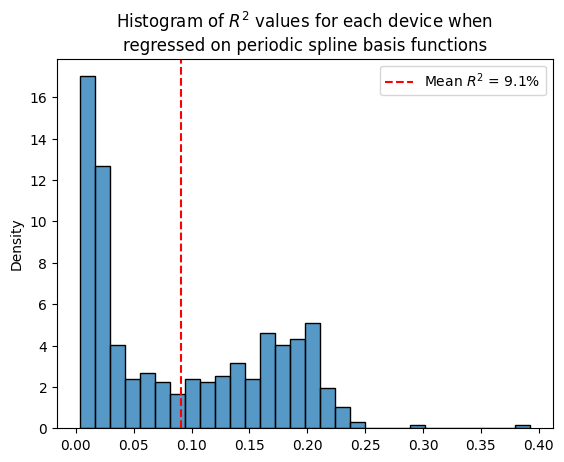

In [4]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import SplineTransformer

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

N_SPLINES = 5

df_hour = df.assign(hour=(np.arange(len(df)) % 24))
splines = periodic_spline_transformer(24, n_splines=N_SPLINES).fit_transform(df_hour[["hour"]])
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
df_hour_spline = df_hour.merge(splines_df, how = "left", left_on = "hour", right_index = True).drop(columns = "hour")

r2s = []
residuals = []
for target_col in df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")]:
    # get ridgecv r^2
    ridgecv = RidgeCV()
    ridgecv.fit(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col])
    r2s.append(ridgecv.score(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]], df_hour_spline[target_col]))
    # get residuals
    residuals.append(df_hour_spline[target_col] - ridgecv.predict(df_hour_spline[["spline_" + str(i) for i in range(N_SPLINES)]]))

r2s = pd.Series(r2s, index = df_hour_spline.columns[df_hour_spline.columns.str.startswith("V")])
sns.histplot(r2s, bins = 30, stat = "density")
plt.title("Histogram of $R^2$ values for each device when\nregressed on periodic spline basis functions")
plt.axvline(r2s.mean(), color = "red", linestyle = "--", label = f"Mean $R^2$ = {r2s.mean() * 100:.1f}%")
plt.legend()

residuals = pd.concat(residuals, axis = 1)
df = residuals

# 2.2. Model base + evaluation

In [5]:
df.iloc[:, 0].head(10)

time
1    -22.342832
2    -22.447433
3    -22.676677
4    -23.213525
5    -23.731821
6    -24.043045
7    -23.780298
8    -22.879719
9    -18.071127
10   -22.235112
Name: V1, dtype: float64

In [6]:
from sklearn.linear_model import RidgeCV
from abc import ABC, abstractmethod
from tqdm import tqdm

class Model(ABC):
    """
    Important:  make sure model.lookback and model.horizon are defined,
    these are used for the get_stats function.
    """
    @abstractmethod
    def fit(self, data):
        """
        Fits a h-step ahead model to the data.
        Forgets the previous fit if model was already fit.

        Parameters
        ----------
        data : pd.DataFrame
            The data to fit the model to.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.

        horizon : int
            The number of steps ahead to forecast.
        """
        ...

    @abstractmethod
    def predict(self, data):
        """
        Predicts X_{t+h} given X_t
        for each X_t (row) in the dataframe `data`.

        Parameters
        ----------
        data : pd.DataFrame
            The data to predict on.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.

        Returns
        -------
        pd.DataFrame
            The predicted values.
            Column for each device (V1 ... VM)
            Row for each time period.
            `time` as index.
        """
        ...


class ARRidgeModel(Model):
    def __init__(self, lookback=5, horizon=1):
        self.lookback = lookback
        self.horizon = horizon

    def fit(self, data):
        models = [RidgeCV() for _ in range(len(data.columns))]
        for col_index, model in enumerate(models):
            col = data.iloc[:, col_index]
            # X[t, :] = [X[t - 0], X[t - 1], ..., X[t - lookback + 1]] (`lookback` lags)
            # y[t] = X[t + horizon] (horizon steps ahead)

            y = col[self.lookback + self.horizon - 1:]
            X = pd.concat([
                col.iloc[i: -self.lookback + i].reset_index(drop=True)
                for i in range(self.lookback)
            ], axis=1, keys=[f"lag_{self.lookback - i - 1}" for i in range(self.lookback)])
            X.index = data.index[self.lookback - 1:-self.horizon]
            y.index = X.index

            model.fit(X, y)


        self.models = models

    def predict(self, data):
        out = []
        for col_index, model in enumerate(self.models):
            col = data.iloc[:, col_index]
            X = pd.concat([
                col.iloc[i: -self.lookback + i].reset_index(drop=True)
                for i in range(self.lookback)
            ], axis=1, keys=[f"lag_{self.lookback - i - 1}" for i in range(self.lookback)])
            X.index = data.index[self.lookback - 1:-self.horizon]
            out.append(model.predict(X))
        return pd.DataFrame(np.array(out).T, index=data.index[self.lookback - 1:-self.horizon], columns=data.columns)

model = ARRidgeModel()
model.fit(df)

In [7]:
model.predict(df)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
5,-21.609712,0.130795,9.060620,6.078143,9.441263,6.749471,7.372986,6.731074,4.158640,6.286853,...,-15.852112,-2.598802,-14.050136,4.033242,-3.104203,-11.036688,-20.389023,-8.094589,-13.876026,-5.616329
6,-21.848652,0.652398,8.960473,6.179871,9.357147,6.474612,7.262740,7.646567,4.236940,6.169366,...,-17.570720,-4.127193,-14.344681,3.867278,-3.459519,-10.661226,-19.865391,-8.118068,-13.635113,-5.954907
7,-21.528783,0.847396,8.573287,5.724376,8.817797,6.195658,7.195781,8.048047,4.421801,5.809350,...,-19.114578,-5.675931,-14.457712,1.889048,-3.387581,-10.284190,-19.390202,-8.188261,-13.375814,-6.073986
8,-20.690041,0.491260,8.029585,5.321931,8.388355,5.578093,6.776615,7.619190,4.492591,5.187185,...,-19.840580,-7.176289,-13.005092,-2.314262,-2.875830,-9.462961,-18.209045,-8.061039,-12.411484,-5.719033
9,-15.827117,2.704877,0.614003,13.522126,1.436389,3.262516,13.860727,3.596001,-1.470061,6.833792,...,-14.534601,22.838171,-18.239156,-9.568567,-10.558534,-11.864407,-22.963172,-18.638912,-19.240872,3.927905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,8.918811,-28.272048,-26.671951,-31.713629,-32.680102,-28.970482,-28.810439,-29.494767,-30.164599,-33.922924,...,-18.883479,-18.271290,-12.507565,-5.348188,-10.367596,-13.308111,-13.989709,-10.546555,-12.549753,-13.016798
740,16.083260,-27.813460,-26.111150,-31.649495,-31.604166,-29.937940,-28.003671,-29.835144,-29.796817,-35.006969,...,-14.597375,-9.499493,-12.758008,-11.153353,-12.248146,-9.886635,-11.749639,-10.228573,-15.450055,-16.120620
741,15.432014,-21.311710,-24.686736,-30.313003,-30.616803,-28.602406,-27.976320,-28.257923,-28.834335,-33.776767,...,-12.783610,-12.298320,-16.496909,-16.348634,-11.990560,-15.245549,-17.013295,-12.117522,-15.531755,-14.407831


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def get_stats(test_data, fitted_model):
    yhat = fitted_model.predict(test_data)
    y = test_data.iloc[fitted_model.lookback + fitted_model.horizon - 1:]
    y.index = yhat.index

    y_flat = y.values.flatten()
    yhat_flat = yhat.values.flatten()

    return pd.Series({
        "mse": mean_squared_error(y_flat, yhat_flat),
        "mae": mean_absolute_error(y_flat, yhat_flat),
        "r2": r2_score(y_flat, yhat_flat)
    })

get_stats(df, model) # in-sample stats

mse    47.526374
mae     4.388347
r2      0.793399
dtype: float64

# 3. Crossval

# 3.1. Crossval visualisation

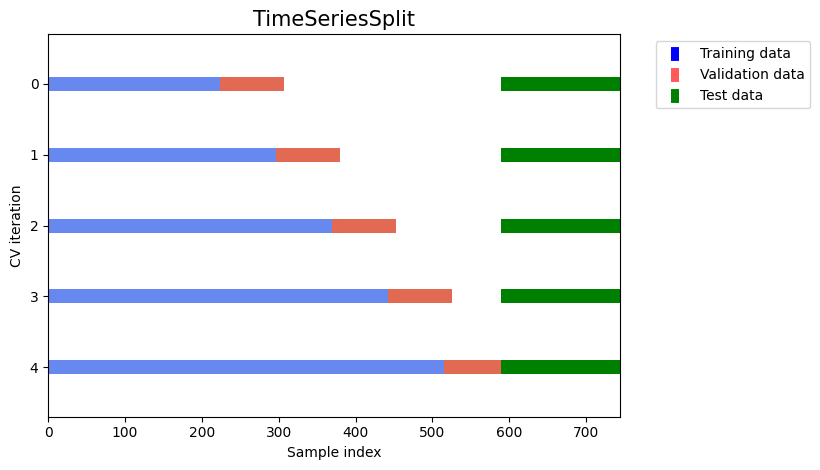

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, TimeSeriesSplit

cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, data_train, data, ax, n_splits, lw=10, lookback = 1, horizon = 1):
    """Create a sample plot for indices of a cross-validation object."""

    # Actual data column doesn't matter for CV visualization
    col = data_train.iloc[:, 0]
    # X[t, :] = [X[t - 0], X[t - 1], ..., X[t - lookback + 1]] (`lookback` lags)
    # y[t] = X[t + horizon] (horizon steps ahead)

    y = col[lookback + horizon - 1:]
    X = pd.concat([
        col.iloc[i: -lookback + i].reset_index(drop=True)
        for i in range(lookback)
    ], axis=1, keys=[f"lag_{lookback - i - 1}" for i in range(lookback)])
    X.index = data_train.index[lookback - 1:-horizon]
    y.index = X.index

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

        # we also draw the test data from (len(X) to len(data))
        # green line
        ax.scatter(
            range(len(X), len(data)),
            [ii + 0.5] * (len(data) - len(X)),
            marker="_",
            lw=lw,
            #c=[1] * (len(data) - len(X)),
            #cmap=cmap_cv,
            #vmin=-0.2,
            #vmax=1.2,
            # we make it green
            c = "green"
        )

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(
        yticks=np.arange(n_splits) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 0.2, -0.2],
        xlim=[0, len(data)],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


TEST_FRAC = 0.2
n_train = int(len(df) * (1 - TEST_FRAC))
n_test = len(df) - n_train
df_train, df_test = df.iloc[:n_train], df.iloc[n_train:]

fig, ax = plt.subplots()
n_splits = 5
cv = TimeSeriesSplit(n_splits, test_size = (len(df) - 5) // 10)
plot_cv_indices(cv, df_train, df, ax, n_splits)
fig.tight_layout()

ax.scatter([], [], marker="_", lw=10, label="Training data", c="b")
ax.scatter([], [], marker="_", lw=10, label="Validation data", c="r", alpha=0.65)
ax.scatter([], [], marker="_", lw=10, label="Test data", c="g")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

Our CV is set up such that we use at least half the data for training.

For the validation, we use 5 folds, and the test set is the last 20% of the data.

# 3.2. Cross-val grid search

In [10]:
def crossval(data, model, cv, horizon = 1, lookback = 5):
    stats = []
    for train_index, test_index in cv.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        model.fit(train)
        stats.append(get_stats(test, model))
    stats = pd.DataFrame(stats).T
    stats.columns.name = "fold"
    stats["mean"] = stats.mean(axis=1)
    return stats

print(crossval(df_train, ARRidgeModel(lookback = 1), cv))
print(crossval(df_train, ARRidgeModel(lookback = 5), cv))

fold          0          1          2          3          4       mean
mse   70.205405  47.185146  47.352487  36.494271  41.774108  48.602284
mae    4.635930   4.611803   4.483055   4.000915   4.589395   4.464220
r2     0.646132   0.727168   0.729988   0.692595   0.721363   0.703449
fold          0          1          2          3          4       mean
mse   60.309812  48.584485  47.196611  35.882234  41.503109  46.695250
mae    4.431848   4.694263   4.456545   3.983331   4.550467   4.423291
r2     0.665892   0.727184   0.725551   0.703163   0.717536   0.707865


In [11]:
from joblib import Parallel, delayed

grid = {
    "lookback": [1, 3, 5, 7, 9, 11, 13, 15]
}

def loss(lookback):
    model = ARRidgeModel(lookback = lookback)
    stats = crossval(df_train, model, cv, lookback = lookback)
    return stats.loc["mse", "mean"] # mean mse across folds

# grid search the loss function
results = pd.DataFrame({
    "lookback": grid["lookback"],
    #"mse": [loss(lookback) for lookback in grid["lookback"]]
    "mse": Parallel(n_jobs=-1)(delayed(loss)(lookback) for lookback in grid["lookback"])
})


Text(0.5, 1.0, 'Grid search')

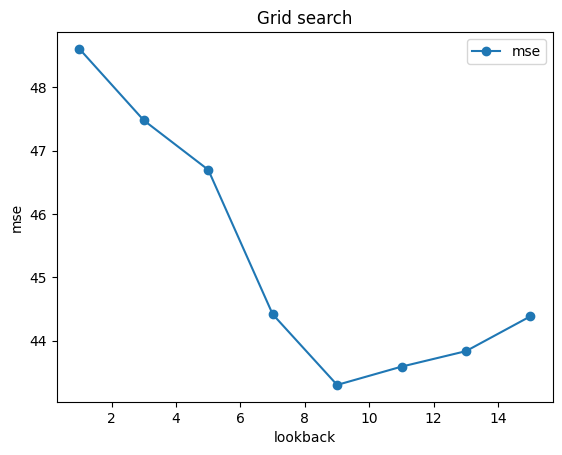

In [12]:
results.plot(x="lookback", y="mse", marker="o")
plt.xlabel("lookback")
plt.ylabel("mse")
plt.title("Grid search")

In [13]:
model = ARRidgeModel(lookback = 9)
model.fit(df_train)
get_stats(df_test, model)

mse    49.868219
mae     4.576650
r2      0.803098
dtype: float64

Naive autoregressive Ridge model per series with a lag length of 9 (found by crossval) leads to a test MSE of 51.629.

# 4.1. VAR model: RRPack

In [14]:
#from statsmodels.tsa import vector_ar
#class VARModel(Model):
    #def __init__(self, lookback=5, horizon=1):
        #self.lookback = lookback
        #self.horizon = horizon

    #def fit(self, data):
        ## each row is a time period, each column is a device
        #self.model = vector_ar.VAR(data)
        

    #def predict(self, data):
        #out = []
        #for col_index, model in enumerate(self.models):
            #col = data.iloc[:, col_index]
            #out.append(model.forecast(col.values[-self.lookback:], self.horizon))
        #return pd.DataFrame(np.array(out).T, index=data.index[-self.horizon:], columns=data.columns)

In [15]:
import os
os.environ['R_HOME'] = '/usr/lib/R'

import rpy2
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.packages import importr
pandas2ri.activate()

sparsevar = importr('sparsevar')
rrpack = importr('rrpack')

In [16]:
r_df_train = pandas2ri.py2rpy(df_train)

In [17]:
#res = sparsevar.fitVAR(r_df_train, p = 1, penalty="ENET", method="cv", scale = True, parallel = True, ncores = 12, nlambda = 64)
X = r["as.matrix"](pandas2ri.py2rpy(df_train.iloc[:-1]))
# add intercept
X = r["cbind"](1, X)
Y = r["as.matrix"](pandas2ri.py2rpy(df_train.iloc[1:]))
Y = r["cbind"](1, Y)
#X = pd.DataFrame(np.random.randn(10, 100))
#Y = pd.DataFrame(np.random.randn(10, 100))
res = rrpack.rrr(Y, X, penaltySVD ="ann", ic_type = "GCV")

<Axes: >

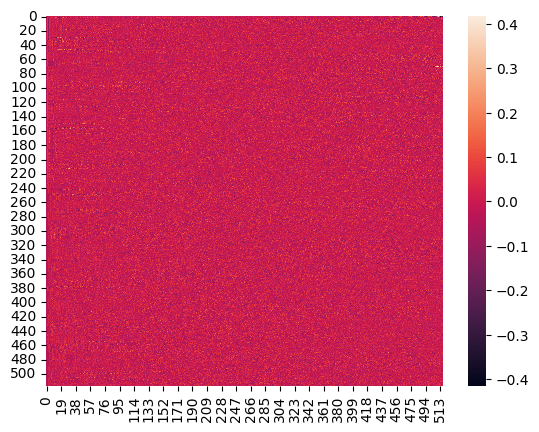

In [18]:
# get res$A
coef = res.rx2("A")
sns.heatmap(coef)

In [19]:
X.shape, Y.shape, coef.shape

((594, 517), (594, 517), (517, 517))

In [20]:
Y - X @ coef.T

array([[ -8.4752532 , -31.71788487,  -8.22432264, ...,  -0.17805816,
        -39.04930459,   1.34713144],
       [ -9.3845815 , -32.1635891 ,  -6.38300738, ...,  -0.25947194,
        -41.23709457,  -1.09419339],
       [ -9.61527335, -32.6837612 ,  -4.66682886, ...,  -0.2980925 ,
        -42.12596047,  -3.62194705],
       ...,
       [-13.7555756 ,  -6.20490245,  14.07735362, ...,  -5.31539989,
        -32.77066198, -47.89721351],
       [-16.93493687,  -7.10728924,  23.93273615, ...,  -7.90207462,
        -46.64004743, -57.29307105],
       [-15.58411311,  -7.33880632,  30.34479831, ...,   1.78093195,
        -47.98338892, -66.44203327]])

In [21]:
# get residuals
residuals = Y - X @ coef.T
# drop the intercept
residuals = residuals[:, 1:]
residuals = pd.DataFrame(np.array(residuals), index = df_train.index[1:], columns = df_train.columns)
residuals


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V507,V508,V509,V510,V511,V512,V513,V514,V515,V516
time,,,,,,,,,,,,,,,,,,,,,
2,-31.717885,-8.224323,-9.895695,13.051618,25.717956,14.227077,-1.234210,-0.885365,-3.441334,-9.035344,...,-23.155102,9.391179,-21.617921,16.010220,-5.195304,-7.571794,-18.827386,-0.178058,-39.049305,1.347131
3,-32.163589,-6.383007,-10.050596,15.023404,26.689221,14.538781,0.747103,-0.707419,-3.102302,-7.744248,...,-26.496659,9.875293,-19.333669,13.588064,-4.735169,-5.889529,-19.015186,-0.259472,-41.237095,-1.094193
4,-32.683761,-4.666829,-9.699587,17.162977,26.757395,14.715022,1.383041,-0.276789,-2.616084,-6.462917,...,-29.512016,9.187945,-17.611543,11.573101,-4.191108,-4.110231,-19.015060,-0.298092,-42.125960,-3.621947
5,-33.224184,-2.934549,-9.179433,18.430413,26.545885,14.901652,1.547155,0.527037,-2.121840,-4.957306,...,-32.631759,7.935096,-16.700371,10.430088,-4.098423,-2.419116,-18.729182,-0.097992,-42.192968,-5.735792
6,-34.009040,-1.317883,-8.127558,19.113124,26.496756,15.208312,1.328136,2.023714,-1.635692,-3.475802,...,-35.947186,6.397592,-15.970239,9.741035,-4.731202,-1.759871,-18.303190,-0.180293,-41.633090,-6.930218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,6.279620,-1.940565,-31.512794,-36.932112,-7.298504,-4.445980,-24.470303,-32.896500,-45.466035,-38.720988,...,-26.343299,-25.615283,-15.375814,12.487386,-12.634438,1.620943,10.464910,-9.635035,-28.266160,-51.998799
592,-1.778792,7.742221,-38.855521,-22.757323,7.441328,2.615668,-32.317854,-31.012448,-33.836982,-34.852243,...,-34.156673,-30.955293,-12.123453,16.407422,1.393084,4.914385,20.090049,4.035906,-22.884629,-42.895962
593,-6.204902,14.077354,-28.317956,-6.210738,6.237622,3.902390,-31.167047,-18.753110,-38.606335,-31.614225,...,-34.121538,-15.820624,-19.494058,10.721683,-0.460138,10.545286,11.256575,-5.315400,-32.770662,-47.897214


# 4.2. Crossval model per cluster

In [22]:
class PerClusterModel(Model):
    def __init__(self, model_generator, clusters):
        self.model_generator = model_generator
        self.clusters = clusters # a list of lists of strings [["V1", ...], ...]

        # ASSUMES ALL MODELS HAVE THE SAME LOOKBACK AND HORIZON
        dummy_model = model_generator()
        self.lookback = dummy_model.lookback
        self.horizon = dummy_model.horizon

    def fit(self, data):
        self.models = [self.model_generator() for _ in range(len(self.clusters))]
        for model, cluster in zip(self.models, self.clusters):
            model.fit(data[cluster])
        

    def predict(self, data):
        # We have to ensure the output is in the same order as data.columns
        out = []
        for model, cluster in zip(self.models, self.clusters):
            out.append(
                pd.DataFrame(model.predict(data[cluster]), columns=cluster)
            )

        return pd.concat(out, axis=1).reindex(data.columns, axis=1)

In [23]:
# Two models, one for the first 100 columns, one for the rest
model = PerClusterModel(lambda: ARRidgeModel(lookback = 5), [df_train.columns[100:], df_train.columns[:100]])
print(crossval(df_train, model, cv))

fold          0          1          2          3          4       mean
mse   60.309812  48.584485  47.196611  35.882234  41.503109  46.695250
mae    4.431848   4.694263   4.456545   3.983331   4.550467   4.423291
r2     0.665892   0.727184   0.725551   0.703163   0.717536   0.707865


In [24]:
print(crossval(df_train, ARRidgeModel(lookback = 5), cv))

fold          0          1          2          3          4       mean
mse   60.309812  48.584485  47.196611  35.882234  41.503109  46.695250
mae    4.431848   4.694263   4.456545   3.983331   4.550467   4.423291
r2     0.665892   0.727184   0.725551   0.703163   0.717536   0.707865


Cluster model works, leads to same results as the non-clustered model for the ARRidgeModel (as expected).

# 4.3. Sparse VAR model